In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import plot_importance

In [22]:
df = pd.read_csv(r"C:\Users\harec\Downloads\test_heart\Cardiovascular_Disease_Dataset.csv")

print(df.shape)

(1000, 14)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientid          1000 non-null   int64  
 1   age                1000 non-null   int64  
 2   gender             1000 non-null   int64  
 3   chestpain          1000 non-null   int64  
 4   restingBP          1000 non-null   int64  
 5   serumcholestrol    1000 non-null   int64  
 6   fastingbloodsugar  1000 non-null   int64  
 7   restingrelectro    1000 non-null   int64  
 8   maxheartrate       1000 non-null   int64  
 9   exerciseangia      1000 non-null   int64  
 10  oldpeak            1000 non-null   float64
 11  slope              1000 non-null   int64  
 12  noofmajorvessels   1000 non-null   int64  
 13  target             1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB


In [24]:
df.describe()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.048704e+06,49.24200,0.765000,0.980000,151.747000,311.447000,0.296000,0.748000,145.477000,0.498000,2.707700,1.540000,1.222000,0.580000
std,2.895905e+06,17.86473,0.424211,0.953157,29.965228,132.443801,0.456719,0.770123,34.190268,0.500246,1.720753,1.003697,0.977585,0.493805
min,1.033680e+05,20.00000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.536440e+06,34.00000,1.000000,0.000000,129.000000,235.750000,0.000000,0.000000,119.750000,0.000000,1.300000,1.000000,0.000000,0.000000
50%,4.952508e+06,49.00000,1.000000,1.000000,147.000000,318.000000,0.000000,1.000000,146.000000,0.000000,2.400000,2.000000,1.000000,1.000000
75%,7.681877e+06,64.25000,1.000000,2.000000,181.000000,404.250000,1.000000,1.000000,175.000000,1.000000,4.100000,2.000000,2.000000,1.000000
max,9.990855e+06,80.00000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


In [25]:
df.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [26]:
numeric_cols = ['age','restingBP','serumcholestrol','maxheartrate','oldpeak']
categorical_cols = ['gender','chestpain','fastingbloodsugar','restingrelectro','exerciseangia','slope','noofmajorvessels','target']

In [27]:
df = df[(df['restingBP'] >= 94) & (df['restingBP'] <= 200)]
df = df[(df['serumcholestrol'] >= 126) & (df['serumcholestrol'] <= 564)]
df = df[(df['maxheartrate'] >= 71) & (df['maxheartrate'] <= 202)]
df = df[(df['oldpeak'] >= 0) & (df['oldpeak'] <= 6.2)]

In [28]:
df['slope'] = df['slope'].replace(0, 1)

In [29]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

In [30]:
df.drop(columns=['patientid'], inplace=True)

In [31]:
df.head()

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
1,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,43,1,0,138,295,1,1,153,0,3.2,2,2,1
6,79,1,2,130,240,0,2,157,0,2.5,2,1,1
7,52,1,0,127,345,0,0,192,1,4.9,1,0,0


In [32]:
df = pd.get_dummies(df, columns=['chestpain','fastingbloodsugar','restingrelectro','exerciseangia','slope','noofmajorvessels'])#, drop_first=True)

In [33]:
df.head()

,age,gender,restingBP,serumcholestrol,maxheartrate,oldpeak,target,chestpain_0,chestpain_1,chestpain_2,...,restingrelectro_2,exerciseangia_0,exerciseangia_1,slope_1,slope_2,slope_3,noofmajorvessels_0,noofmajorvessels_1,noofmajorvessels_2,noofmajorvessels_3
1,40,1,94,229,115,3.7,0,True,False,False,...,False,True,False,True,False,False,False,True,False,False
2,49,1,133,142,202,5.0,0,False,False,True,...,False,False,True,True,False,False,True,False,False,False
3,43,1,138,295,153,3.2,1,True,False,False,...,False,True,False,False,True,False,False,False,True,False
6,79,1,130,240,157,2.5,1,False,False,True,...,True,True,False,False,True,False,False,True,False,False
7,52,1,127,345,192,4.9,0,True,False,False,...,False,False,True,True,False,False,True,False,False,False


In [34]:
for col in numeric_cols:
    if abs(df[col].skew()) > 1:
        df[col] = np.log1p(df[col])

<Axes: >

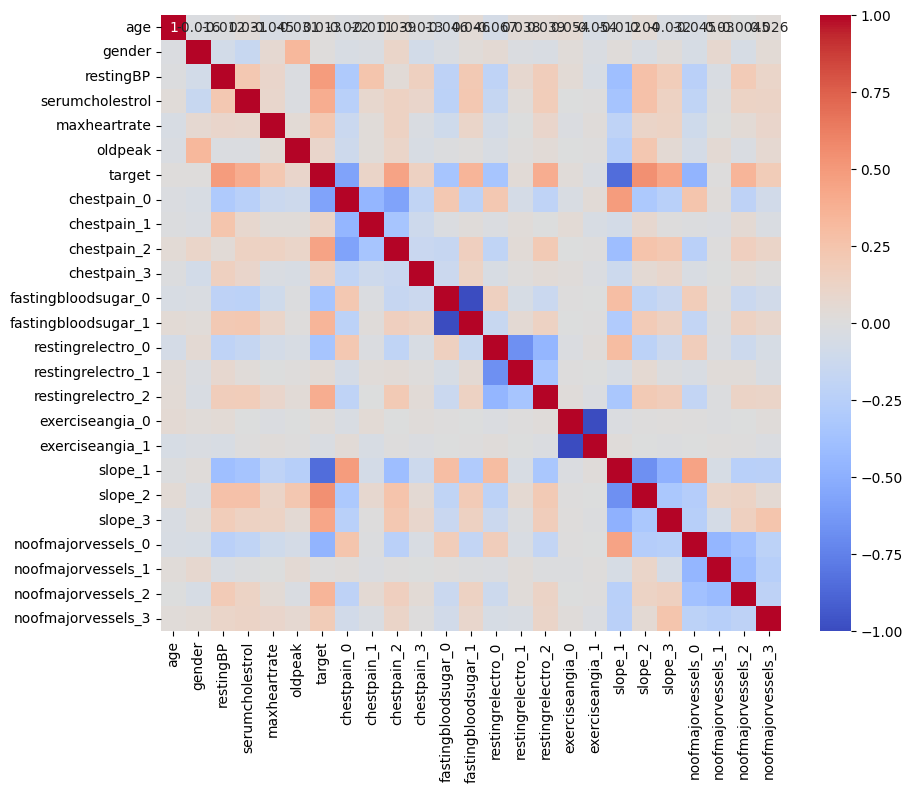

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [36]:
df.head()

,age,gender,restingBP,serumcholestrol,maxheartrate,oldpeak,target,chestpain_0,chestpain_1,chestpain_2,...,restingrelectro_2,exerciseangia_0,exerciseangia_1,slope_1,slope_2,slope_3,noofmajorvessels_0,noofmajorvessels_1,noofmajorvessels_2,noofmajorvessels_3
1,40,1,94,229,115,3.7,0,True,False,False,...,False,True,False,True,False,False,False,True,False,False
2,49,1,133,142,202,5.0,0,False,False,True,...,False,False,True,True,False,False,True,False,False,False
3,43,1,138,295,153,3.2,1,True,False,False,...,False,True,False,False,True,False,False,False,True,False
6,79,1,130,240,157,2.5,1,False,False,True,...,True,True,False,False,True,False,False,True,False,False
7,52,1,127,345,192,4.9,0,True,False,False,...,False,False,True,True,False,False,True,False,False,False


In [37]:
import xgboost as xgb
# ✅ Selected important features based on SHAP and importance analysis
selected_features = [
    'restingBP',
    'serumcholestrol',
    'maxheartrate',
    'oldpeak',
    'age',
    'slope_1',
    'chestpain_0',
    'chestpain_2',
    'gender',
    'restingrelectro_0',
    'noofmajorvessels_2'
]

# Split features and label
X = df[selected_features]
y = df['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost classifier
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)


c:\Users\harec\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:47:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
# Predict and evaluate
y_pred = model_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.946524064171123
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94        91
           1       0.94      0.96      0.95        96

    accuracy                           0.95       187
   macro avg       0.95      0.95      0.95       187
weighted avg       0.95      0.95      0.95       187



In [39]:
test_data = pd.DataFrame([
    [130, 250, 140, 1.0, 52, 1, 1, 0, 1, 1, 0],  # ✅ Disease
    [120, 220, 160, 0.0, 45, 1, 1, 0, 0, 1, 0],  # ❌ No
    [140, 270, 120, 2.5, 60, 1, 0, 1, 1, 0, 1],  # ✅ Disease
    [110, 180, 170, 0.0, 39, 1, 1, 0, 1, 1, 0],  # ❌ No
    [150, 300, 100, 3.0, 67, 0, 0, 1, 0, 0, 1],  # ✅ Disease
    [125, 240, 150, 1.2, 54, 1, 1, 0, 1, 0, 0],  # ❌ No
    [145, 280, 115, 2.8, 61, 1, 0, 1, 1, 0, 1],  # ✅ Disease
    [135, 260, 135, 1.8, 59, 1, 0, 1, 1, 0, 1],  # ✅ Disease
    [115, 190, 165, 0.0, 43, 1, 1, 0, 0, 1, 0],  # ❌ No
    [160, 310, 95, 4.0, 70, 0, 0, 1, 1, 0, 1]    # ✅ Disease
], columns=selected_features)

# Make predictions using your trained model
predictions = model_xgb.predict(test_data)

# Optional: print results
for i, pred in enumerate(predictions):
    status = "✅ Heart Disease" if pred == 1 else "❌ No Heart Disease"
    print(f"Person {i+1}: {status}")


Person 1: ❌ No Heart Disease
Person 2: ❌ No Heart Disease
Person 3: ❌ No Heart Disease
Person 4: ❌ No Heart Disease
Person 5: ✅ Heart Disease
Person 6: ❌ No Heart Disease
Person 7: ❌ No Heart Disease
Person 8: ✅ Heart Disease
Person 9: ❌ No Heart Disease
Person 10: ✅ Heart Disease


In [40]:
# Save best XGBoost model
joblib.dump(model_xgb, 'xgb_heart_model_final.pkl')

['xgb_heart_model_final.pkl']